# Liver CT Scan Image Enhancement Using GAN

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

##### Extract the zip files

In [ ]:
import zipfile

with zipfile.ZipFile('Enhanced_images_for_GAN.zip', 'r') as zip_ref:
    zip_ref.extractall('/GAN_Trainign_data')

with zipfile.ZipFile('train_images_vol_GAN.zip', 'r') as zip_ref:
    zip_ref.extractall('/GAN_Trainign_data')

In [ ]:
!pip install tensorflow==2.10.1

In [21]:
# Create a directory for saving model, dataset, weights
import os
save_dir = '/Model_Save'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [1]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization, Input, ReLU, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import time
import os
import cv2
import glob
from joblib import Parallel, delayed
from sklearn.model_selection import train_test_split
# Enable mixed precision
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA RTX A6000, compute capability 8.6


### **Build GAN**

#### Build Generator model



In [4]:
  # Generator Model: Multi-level encoder-decoder with skip connections
  def build_generator(input_shape):
      inputs = Input(shape=input_shape)
      # input_layer = Input(shape=input_shape)
      # Encoder-Decoder blocks
      def encoder_block(x, filters, kernel_size=3, dilation_rate=1):
          x = Conv2D(filters, kernel_size, dilation_rate=dilation_rate, padding='same')(x)
          x = BatchNormalization()(x)
          x = ReLU()(x)
          return x

      def decoder_block(x, filters, kernel_size=3, dilation_rate=1):
          x = Conv2DTranspose(filters, kernel_size, dilation_rate=dilation_rate, padding='same')(x)
          x = BatchNormalization()(x)
          x = ReLU()(x)
          return x

      # Multi-scale encoding
      e1 = encoder_block(inputs, 32, dilation_rate=1)
      e2 = encoder_block(e1, 64, dilation_rate=2)
      e3 = encoder_block(e2, 128, dilation_rate=4)

      # Multi-scale decoding
      d1 = decoder_block(e3, 64, dilation_rate=2)
      d2 = decoder_block(d1, 32, dilation_rate=1)

      outputs = Conv2D(1, (1, 1), activation='tanh', padding='same')(d2)

      return Model(inputs, outputs)

#### Discriminator model

In [5]:
# Discriminator Model
def build_discriminator(input_shape):
    inputs = Input(shape=input_shape)
    # input_layer = Input(shape=input_shape)
    x = Conv2D(64, (4, 4), strides=2, padding='same')(inputs)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(128, (4, 4), strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(256, (4, 4), strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(512, (4, 4), strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(1, (4, 4), padding='same')(x)

    # Flatten to get a single output
    x = Flatten()(x)
    outputs = Dense(1, activation='sigmoid')(x)  # Single probability output

    return Model(inputs, outputs)

In [6]:
# Combined GAN
def build_gan(generator, discriminator):
    discriminator.trainable = True  # Only train the generator in the combined model
    gan_input = Input(shape=input_shape)  # Input shape (for low contrast images)
    generated_image = generator(gan_input)
    gan_output = discriminator(generated_image)
    return Model(gan_input, gan_output)

#### Loss functions

##### VGG molde for content loss

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.applications import VGG16

def get_vgg16_model(input_shape=(128, 128, 1)):
    # Define the input layer for grayscale images
    input_layer = Input(shape=input_shape)

    # Add a 1x1 convolutional layer to convert 1 channel to 3 channels
    x = Conv2D(3, (1, 1), activation='relu', padding='same')(input_layer)  # Convert grayscale to pseudo-RGB

    # Load VGG16 without the top layer and with pre-trained weights
    vgg = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))  # Use 3 channels

    # Pass the output of the 1x1 convolution to the VGG16 model
    vgg_output = vgg(x)

    # Set the VGG16 model to be non-trainable
    vgg.trainable = False

    # Create the model
    model = tf.keras.Model(inputs=input_layer, outputs=vgg_output)  # Use the output from VGG16
    return model

# Example usage
input_shape = (128, 128, 1)  # Grayscale input
vgg_model = get_vgg16_model(input_shape=input_shape)
vgg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 3)       6         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
Total params: 14,714,694
Trainable params: 6
Non-trainable params: 14,714,688
_________________________________________________________________


##### Adversarial Loss

In [8]:
def adversarial_loss(discriminator, generated_images):
    return tf.reduce_mean(discriminator(generated_images))

##### Content Loss

In [9]:
def content_loss(reference_images, generated_images, vgg_model):
    ref_features = vgg_model(reference_images)
    gen_features = vgg_model(generated_images)
    return tf.reduce_mean(tf.square(ref_features - gen_features))

##### Combined Loss

In [10]:
ALPHA = 0.1
BETA = 0.01

def combined_loss(discriminator, generated_images, reference_images, vgg_model):
    adv_loss = adversarial_loss(discriminator, generated_images)
    content_loss = content_loss(reference_images, generated_images, vgg_model)
    total_loss = ALPHA * adv_loss + BETA * content_loss
    return total_loss

### Load Data

In [10]:
# ============ Loading Entire dataset  ===========

import os
import cv2
import glob
from sklearn.model_selection import train_test_split
import numpy as np

# # Directories for raw and enhanced images
raw_images_dir = 'GAN Training dataset/Enhanced_images/train_images_vol'
enhanced_images_dir = 'GAN Training dataset/train_images_vol/train_images_vol'

# # Function to load paired images
def load_paired_images(raw_dir, enhanced_dir, target_size=(128, 128)):
    raw_images = []
    enhanced_images = []

    # Loop through all subfolders (vol 1, vol 2, ...)
    for folder in os.listdir(raw_dir):
        raw_folder = os.path.join(raw_dir, folder)
        enhanced_folder = os.path.join(enhanced_dir, folder)

        if os.path.isdir(raw_folder) and os.path.isdir(enhanced_folder):
             raw_files = glob.glob(os.path.join(raw_folder, '*.jpg'))  # Adjust extension if needed
             for raw_file in raw_files:
                 filename = os.path.basename(raw_file)  # Extract filename
                 enhanced_file = os.path.join(enhanced_folder, filename)  # Match with enhanced

                 if os.path.exists(enhanced_file):  # Ensure both raw and enhanced exist
                    # ==== Data Augumentation on Raw images====
                     raw_image = cv2.imread(raw_file, cv2.IMREAD_GRAYSCALE)
                     raw_image = cv2.resize(raw_image, target_size) / 127.5 - 1  # Resize and normalize
                   
                     enhanced_image = cv2.imread(enhanced_file, cv2.IMREAD_GRAYSCALE)
                     enhanced_image = cv2.resize(enhanced_image, target_size) / 127.5 - 1  # Resize and normalize

                     raw_images.append(raw_image)
                     enhanced_images.append(enhanced_image)

    return np.array(raw_images), np.array(enhanced_images)

# # Load all paired images
raw_images, enhanced_images = load_paired_images(raw_images_dir, enhanced_images_dir)

# # Add a channel dimension for TensorFlow (shape: [height, width, 1])
raw_images = raw_images[..., np.newaxis]
enhanced_images = enhanced_images[..., np.newaxis]

 # Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(raw_images, enhanced_images, test_size=0.2, random_state=42)

# X_train = X_train[:1000]
# y_train = y_train[:1000]
# X_val = X_val[:1000]
# y_val = y_val[:1000]
print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")

Training samples: 46850, Validation samples: 11713


In [37]:
# ============ Loading specified amount of data ===========

import os
import cv2
import glob
from sklearn.model_selection import train_test_split
import numpy as np

# # Directories for raw and enhanced images
raw_images_dir = 'GAN Training dataset/Enhanced_images/train_images_vol'
enhanced_images_dir = 'GAN Training dataset/train_images_vol/train_images_vol'
limit = 100   #Specify the limit(number of images) to load data

# # Function to load paired images
def load_paired_images(raw_dir, enhanced_dir, target_size=(128, 128), limit=limit):
    raw_images = []
    enhanced_images = []
    count = 0

    # Loop through all subfolders (e.g., vol 1, vol 2)
    for folder in os.listdir(raw_dir):
        raw_folder = os.path.join(raw_dir, folder)
        enhanced_folder = os.path.join(enhanced_dir, folder)

        if os.path.isdir(raw_folder) and os.path.isdir(enhanced_folder):
             raw_files = glob.glob(os.path.join(raw_folder, '*.jpg'))  # Adjust extension if needed
             for raw_file in raw_files:
                # count 
                 if count >= limit:
                    break
                     
                 filename = os.path.basename(raw_file)  # Extract filename
                 enhanced_file = os.path.join(enhanced_folder, filename)  # Match with enhanced

                 if os.path.exists(enhanced_file):  # Ensure both raw and enhanced exist
                    # ==== Data Augumentation on Raw images====
                     raw_image = cv2.imread(raw_file, cv2.IMREAD_GRAYSCALE)
                     raw_image = cv2.resize(raw_image, target_size) / 127.5 - 1  # Resize and normalize
            
                     enhanced_image = cv2.imread(enhanced_file, cv2.IMREAD_GRAYSCALE)
                     enhanced_image = cv2.resize(enhanced_image, target_size) / 127.5 - 1  # Resize and normalize
                     
                     raw_images.append(raw_image)
                     enhanced_images.append(enhanced_image)

                     count += 1
                     if count >= limit:
                        break

    return np.array(raw_images), np.array(enhanced_images)

# Load all paired images
raw_images, enhanced_images = load_paired_images(raw_images_dir, enhanced_images_dir, limit=limit)

# Add a channel dimension for TensorFlow (shape: [height, width, 1])
raw_images = raw_images[..., np.newaxis]
enhanced_images = enhanced_images[..., np.newaxis]

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(raw_images, enhanced_images, test_size=0.2, random_state=42)

print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")
print('Shape of \nx_train: ',X_train.shape, '; y_train: ',y_train.shape, '; x_val: ',X_val.shape, '; y_val: ',y_val.shape)

Training samples: 80, Validation samples: 20
Shape of 
x_train:  (80, 128, 128, 1) ; y_train:  (80, 128, 128, 1) ; x_val:  (20, 128, 128, 1) ; y_val:  (20, 128, 128, 1)


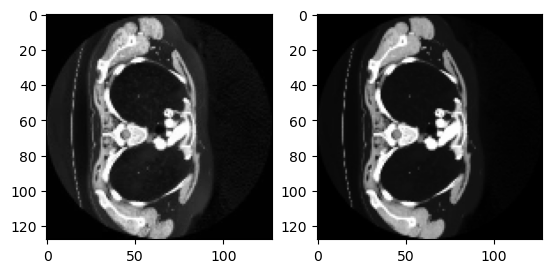

In [14]:
import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)
plt.imshow(X_train[10], cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(y_train[10], cmap='gray')
# plt.imshow(X_train[0], cmap='BrBG')
plt.show()

In [15]:
# Define training parameters
input_shape = (128, 128, 1)
generator = build_generator(input_shape)
discriminator = build_discriminator((128, 128, 1))
gan_model = build_gan(generator, discriminator)
vgg_model = get_vgg16_model(input_shape=input_shape)

In [16]:
generator.summary()
discriminator.summary()
gan_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 128, 128, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 64)     256       
 hNormalization)                                           

#### Compile the model without loss functions

In [17]:
# Compile models
discriminator.compile(optimizer=Adam(learning_rate=0.0004))
gan_model.compile(optimizer=Adam(learning_rate=0.0004))

In [19]:
# Train the GAN
epochs = 69 # Number of epochs
batch_size = 32

In [22]:
# Save whole model - architecture, optimizer state, and weights in the Keras format.
checkpoint = ModelCheckpoint(f"{save_dir}/gan_generator.keras", monitor='val_loss', save_best_only=True, mode='min')

In [23]:
# Save the weights in .h5 format separately
class SaveWeightsCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        self.model.save_weights(f"{save_dir}/gan_generator_weights_epoch_{epoch}.h5")

# Add early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Callback for saving both the model and weights
callbacks = [checkpoint, SaveWeightsCallback(), early_stopping]

In [24]:
start_time = time.time()

def estimate_time(epoch, epochs, start_time):
    elapsed_time = time.time() - start_time
    time_per_epoch = elapsed_time / (epoch + 1)
    remaining_time = time_per_epoch * (epochs - epoch - 1)
    print(f"Epoch {epoch}/{epochs} - Estimated time remaining: {remaining_time // 60:.0f} minutes")


##### Model Output visualization

In [25]:
import matplotlib.pyplot as plt
def visualize_generated_images(generator, low_contrast_images, epochs, save_dir=None):
    """
    Visualize generated images alongside their corresponding low-contrast inputs.
    Optionally save the visualization as an image file.
    """
    # Generate fake images
    generated_images = generator.predict(low_contrast_images)

    # Plot the results
    plt.figure(figsize=(15, 5))
    for i in range(min(len(low_contrast_images), 5)):  # Display up to 5 images
        # Low-contrast input
        plt.subplot(3, 5, i + 1)
        plt.title("Low Contrast Input")
        plt.imshow(low_contrast_images[i].squeeze(), cmap="gray")
        plt.axis("off")

        # Generated (enhanced) image
        plt.subplot(3, 5, i + 1 + 5)
        plt.title("Generated Image")
        plt.imshow(generated_images[i].squeeze(), cmap="gray")
        plt.axis("off")

    plt.tight_layout()
    if save_dir:
        plt.savefig(f"{save_dir}/epochs{epochs}_visualization.png")
    plt.show()

#### Training loop 

In [26]:
# Train the GAN model with combined adversarial and content losses for the generator and BCE for the discriminator.

def train_gan_with_custom_loss(generator, discriminator, vgg_model, X_train, y_train, X_val, y_val, epochs, batch_size, save_dir):
    # Optimizers for generator and discriminator
    optimizer_gen = Adam(learning_rate=0.0002)
    optimizer_disc = Adam(learning_rate=0.0002)

    num_batches = len(X_train) // batch_size

    for epoch in range(epochs):
        for i in range(num_batches):
            # Select real and low-contrast images for the current batch
            real_images = tf.convert_to_tensor(y_train[i * batch_size: (i + 1) * batch_size], dtype=tf.float32)  # Ensure float32
            low_contrast_images = tf.convert_to_tensor(X_train[i * batch_size: (i + 1) * batch_size], dtype=tf.float32)  # Ensure float32

            # --- Train Discriminator ---
            with tf.GradientTape() as disc_tape:
                # Generate fake images
                fake_images = generator(low_contrast_images, training=True)

                # Discriminator loss for real and fake images
                real_labels = tf.ones((batch_size, 1), dtype=tf.float32)  # Ensure float32
                fake_labels = tf.zeros((batch_size, 1), dtype=tf.float32)  # Ensure float32

                # Discriminator predictions
                real_predictions = discriminator(real_images, training=True)
                fake_predictions = discriminator(fake_images, training=True)

                # Compute BCE loss
                real_loss = tf.keras.losses.BinaryCrossentropy()(real_labels, real_predictions)
                fake_loss = tf.keras.losses.BinaryCrossentropy()(fake_labels, fake_predictions)
                disc_loss = 0.5 * (real_loss + fake_loss)

            # Apply discriminator gradients
            gradients_disc = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
            optimizer_disc.apply_gradients(zip(gradients_disc, discriminator.trainable_variables))

            # --- Train Generator ---
            with tf.GradientTape() as gen_tape:
                # Generate fake images
                fake_images = generator(low_contrast_images, training=True)

                # Adversarial loss (fake images classified as real)
                adv_labels = tf.ones((batch_size, 1), dtype=tf.float32)  # Ensure float32
                adv_loss = tf.keras.losses.BinaryCrossentropy()(adv_labels, discriminator(fake_images, training=True))

                # Content loss (compare VGG features)
                real_features = vgg_model(real_images, training=False)  # Already RGB
                fake_features = vgg_model(fake_images, training=False)  # Already RGB
                content_loss = tf.reduce_mean(tf.square(real_features - fake_features))

                # Combined loss
                gen_loss = adv_loss + content_loss

            # Apply generator gradients
            gradients_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
            optimizer_gen.apply_gradients(zip(gradients_gen, generator.trainable_variables))

            # Print progress every 10 batches
            if i % 10 == 0:
                print(f"Epoch {epoch + 1}/{epochs} - Batch {i + 1}/{num_batches} | D Loss: {disc_loss:.4f}, G Loss: {gen_loss:.4f}")

        # Save generator model periodically
        if (epoch + 1) % 5 == 0 or epoch == epochs - 1:
            generator.save(f"{save_dir}/generator_epoch_{epoch + 1}.h5")

        # Validation Loss
        val_fake_images = generator(X_val, training=False)
        val_adv_loss = tf.keras.losses.BinaryCrossentropy()(
            tf.ones((len(X_val), 1), dtype=tf.float32),  # Ensure float32
            discriminator(val_fake_images, training=False)
        )

        # Calculate content loss for validation
        val_real_features = vgg_model(tf.convert_to_tensor(y_val, dtype=tf.float32))  # Ensure float32
        val_fake_features = vgg_model(tf.cast(tf.convert_to_tensor(val_fake_images), dtype=tf.float32))  # Ensure float32
        # val_fake_features = vgg_model(tf.convert_to_tensor(val_fake_images, dtype=tf.float32))  # Ensure float32
        val_content_loss = tf.reduce_mean(tf.square(val_real_features - val_fake_features))

        # Total validation loss
        val_loss = val_adv_loss + val_content_loss

        print(f"Validation Loss at Epoch {epoch + 1}: {val_loss.numpy():.4f}")


In [27]:
train_gan_with_custom_loss(generator, discriminator, vgg_model, X_train, y_train, X_val, y_val, epochs, batch_size, save_dir)

Epoch 1/69 - Batch 1/2 | D Loss: 0.8428, G Loss: 5.8320
Validation Loss at Epoch 1: 0.7793
Epoch 2/69 - Batch 1/2 | D Loss: 0.1042, G Loss: 13.3672
Validation Loss at Epoch 2: 0.7715
Epoch 3/69 - Batch 1/2 | D Loss: 0.1321, G Loss: 11.5391
Validation Loss at Epoch 3: 0.7603
Epoch 4/69 - Batch 1/2 | D Loss: 0.0091, G Loss: 5.2852
Validation Loss at Epoch 4: 0.7583
Epoch 5/69 - Batch 1/2 | D Loss: 0.0693, G Loss: 8.2109
Validation Loss at Epoch 5: 0.7627
Epoch 6/69 - Batch 1/2 | D Loss: 0.0125, G Loss: 10.5391
Validation Loss at Epoch 6: 0.7681
Epoch 7/69 - Batch 1/2 | D Loss: 0.0629, G Loss: 9.1641
Validation Loss at Epoch 7: 0.7749
Epoch 8/69 - Batch 1/2 | D Loss: 0.0186, G Loss: 6.0156
Validation Loss at Epoch 8: 0.7861
Epoch 9/69 - Batch 1/2 | D Loss: 0.0368, G Loss: 5.9180
Validation Loss at Epoch 9: 0.8027
Epoch 10/69 - Batch 1/2 | D Loss: 0.0139, G Loss: 7.0000
Validation Loss at Epoch 10: 0.8203
Epoch 11/69 - Batch 1/2 | D Loss: 0.0131, G Loss: 6.7734
Validation Loss at Epoch 11:

1/1 [==============================] - 1s 700ms/step


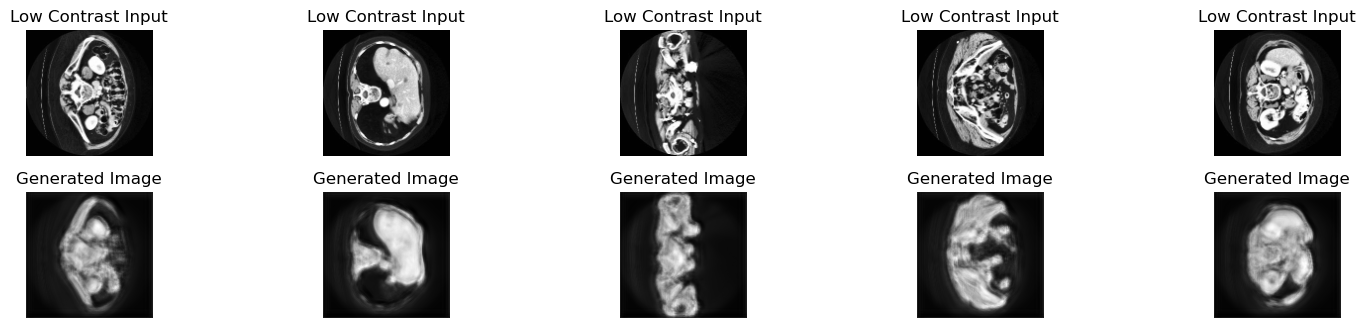

In [28]:
visualize_generated_images(generator, X_train[:5], epochs, save_dir)

In [30]:
# Save model
generator.save(f'Model_save/generator_epoch_{epochs}.h5')
discriminator.save(f'Model_save/discriminator_epoch_{epochs}.h5')

In [29]:
# Save model
generator.save(f'Model_save/generator_epoch_{epochs}.keras')
discriminator.save(f'Model_save/discriminator_epoch_{epochs}.keras')